## N차 과제 - Time Series Analysis_주가예측

- 주제: 시계열 모델을 주가 데이터에 대한 시계열 예측 및 분석
- 데이터: 주식 데이터(크롤링 or 라이브러리로 데이터 불러오기)
- 사용 라이브러리: yfinance, datareader, statsmodels, matplotlib etc.

In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose


### 1. EDA 및 전처리

1.1 분석을 위해 사용할 특정 주식(1개)의 데이터를 불러오거나 크롤링하여 가져오세요(**최소 3년 이상의 데이터 추출 권고**).

In [2]:
start = "2021-01-01"
end = "2023-12-31"
ticker = "005930.KS"       # 삼성전자 주식
df = yf.download(ticker, start, end)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,81000.0,84400.0,80200.0,83000.0,77225.757812,38655276
2021-01-05,81600.0,83900.0,81600.0,83900.0,78063.140625,35335669
2021-01-06,83300.0,84500.0,82100.0,82200.0,76481.406250,42089013
2021-01-07,82800.0,84200.0,82700.0,82900.0,77132.703125,32644642
2021-01-08,83300.0,90000.0,83000.0,88800.0,82622.250000,59013307
...,...,...,...,...,...,...
2023-12-21,74600.0,75000.0,74300.0,75000.0,73978.890625,13478766
2023-12-22,75800.0,76300.0,75400.0,75900.0,74866.632812,14515608
2023-12-26,76100.0,76700.0,75700.0,76600.0,75557.109375,13164909


1.2 결측치가 있는지 확인하고 있다면 제거해주세요.

In [3]:
df.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


1.3 일자를 인덱스로 설정하고 시간 순서대로 정렬하세요.

In [4]:
df = df.reset_index()
df = df.set_index('Date')
df = df.sort_index()
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,81000.0,84400.0,80200.0,83000.0,77225.757812,38655276
2021-01-05,81600.0,83900.0,81600.0,83900.0,78063.140625,35335669
2021-01-06,83300.0,84500.0,82100.0,82200.0,76481.406250,42089013
2021-01-07,82800.0,84200.0,82700.0,82900.0,77132.703125,32644642
2021-01-08,83300.0,90000.0,83000.0,88800.0,82622.250000,59013307
...,...,...,...,...,...,...
2023-12-21,74600.0,75000.0,74300.0,75000.0,73978.890625,13478766
2023-12-22,75800.0,76300.0,75400.0,75900.0,74866.632812,14515608
2023-12-26,76100.0,76700.0,75700.0,76600.0,75557.109375,13164909


1.4 수정종가(adj close)와 거래량(volume)을 시각화하세요.

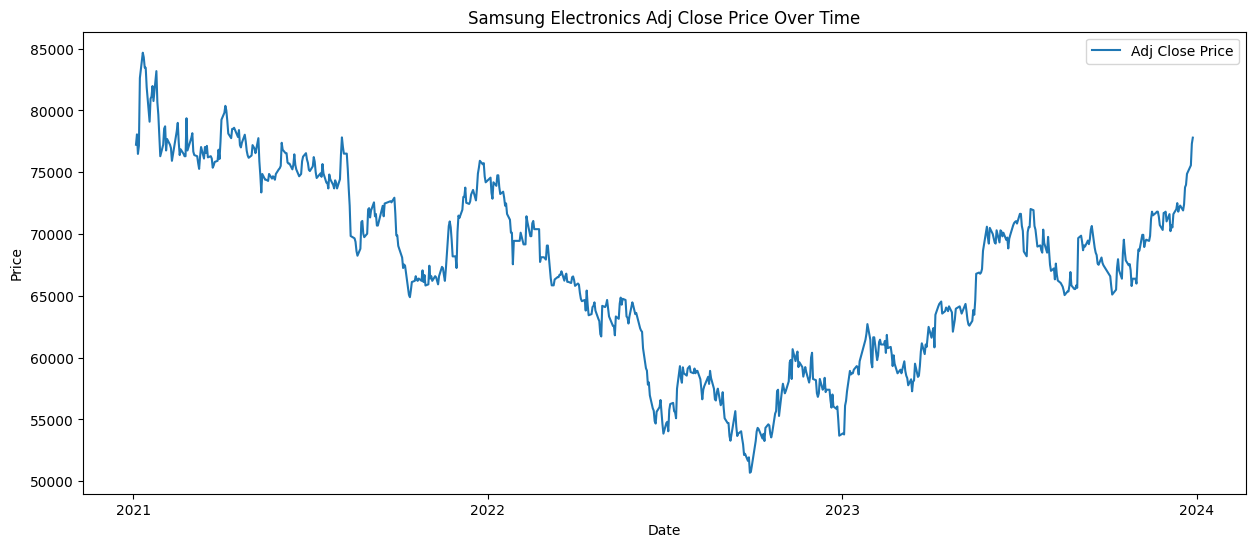

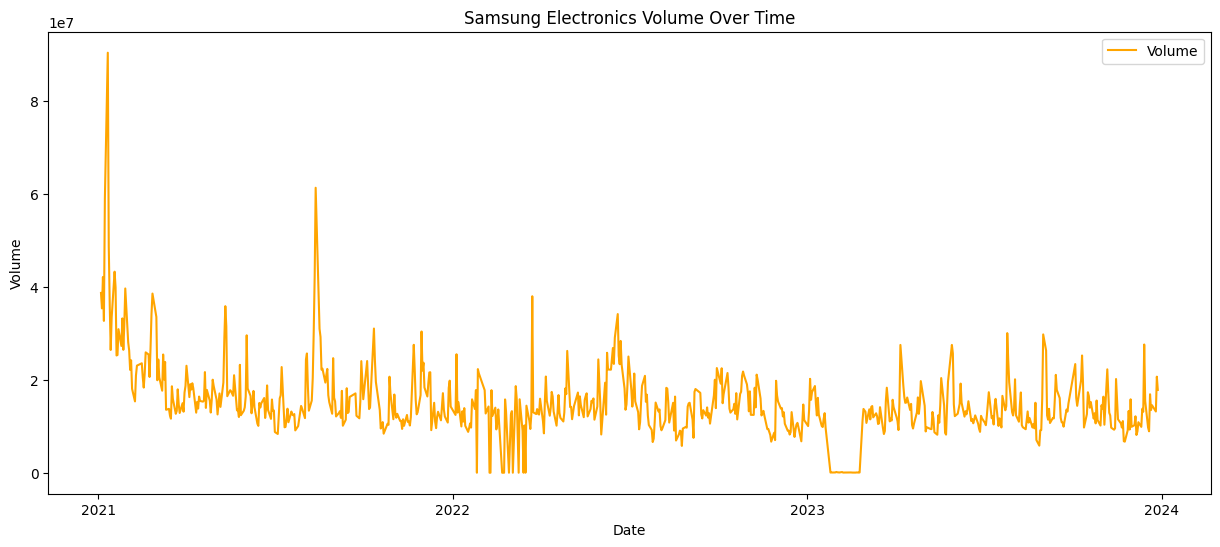

In [5]:
import matplotlib.dates as mdates

# 수정종가 시각화
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Adj Close'], label='Adj Close Price')
plt.legend()
plt.title('Samsung Electronics Adj Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# 거래량 시각화
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Volume'], label='Volume', color = 'orange')
plt.legend()
plt.title('Samsung Electronics Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

1.5 위 시각화 과정을 통해 알 수 있는 내용에 대해 작성하세요.

- 수정종가의 경우 2021년에 85000으로 상한가를 쳤다가 꾸준히 하락하면서 2022년 후반에 최하를 기록했다. 이후로는 꾸준히 상승 중이다.
- 거래량의 경우 2021년에 상한을 친 후에는 2 사이에서 꾸준히 유지 중이다.2022년 초반, 2023년 초반 잠깐씩 하한을 칠 때도 있지만 곧바로 회복한다.

### 2. 추세 및 정상성 검정

2.1 시계열 데이터의 정상성을 검증하도록 하겠습니다. 시계열 데이터 말하는 정상성(stationarity)이 무엇인지 왜 해야 하며 비정상성의 해결 방법에는 무엇이 있는지 작성하세요.

- 정상성이란 시간에 상관없이 일정한 성질을 갖고 있는 것을 의미한다.
- 시계열 분석의 경우 정상성을 갖고 있다면, 시계열의 평균과 분산이 일정하다. 그래서, 정상성을 갖고 있어야 시계열 값을 예측할 수 있기 때문에 중요하다.
- 비정상성을 해결하는 방법은 차분, 로그 변환, 로그 차분 등이 있다.
- 차분의 경우는 평균을 일정하게 만들고, 로그 변환은 분산을 줄여준다. 로그 차분의 경우는 이 둘을 합친 방법으로 이해하면 된다.

2.2 먼저 ADF Test를 수행하겠습니다. statsmodels의 adfuller 라이브러리를 import 한 후 수정 종가에 대한 검정을 수행하고 결과를 출력하세요(p-value 포함).

ADF Test란? - https://hongl.tistory.com/98

In [6]:
result = adfuller(df['Adj Close'])

print(f'ADF statistics : {result[0]}')
print(f'p-value : {result[1]}')

ADF statistics : -1.4836112219016642
p-value : 0.5416024950932624


2.3 ADF Test 결과를 해석하세요.

- ADF 통계량이 약 -1.48인데, 음수일 경우 시계열 데이터가 안정적이라는 것을 의미한다.
- 그러나, p-value가 약 0.54로 유의수준 0.05보다 크므로 시계열 데이터가 불안정하다고 볼 수 있다.

2.4 ACF 그래프와 PACF 그래프를 그려보도록 하겠습니다. 먼저 ACF와 PACF 각각이 어떻게 다른지 설명하세요.

- ACF는 k시간 단위로 구분된 시계열 관측치 간의 yt와 yt+k간 상관관계를 측정하는 것이다.
- PACF는 ACF의 한계를 보완하기 위한 추가적인 분석 기법으로 ACF의 원리를 따르되, t와 t+k 간 다른 y의 영향력은 배제하고 측정하는 방식이다.

2.5 statsmodels의 plot_acf, plot_pacf 라이브러리를 import하고 Adj close값에 대한 ACF, PACF 그래프를 출력하세요.

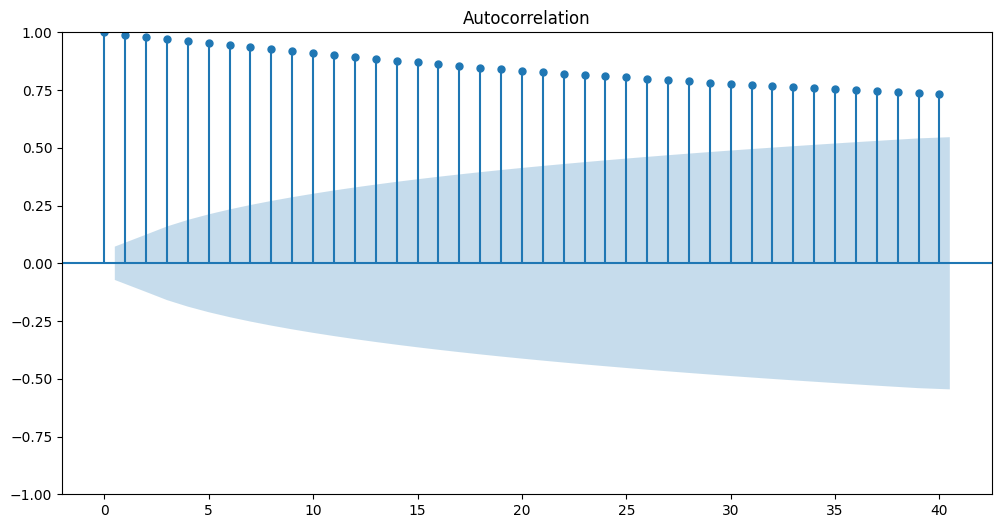

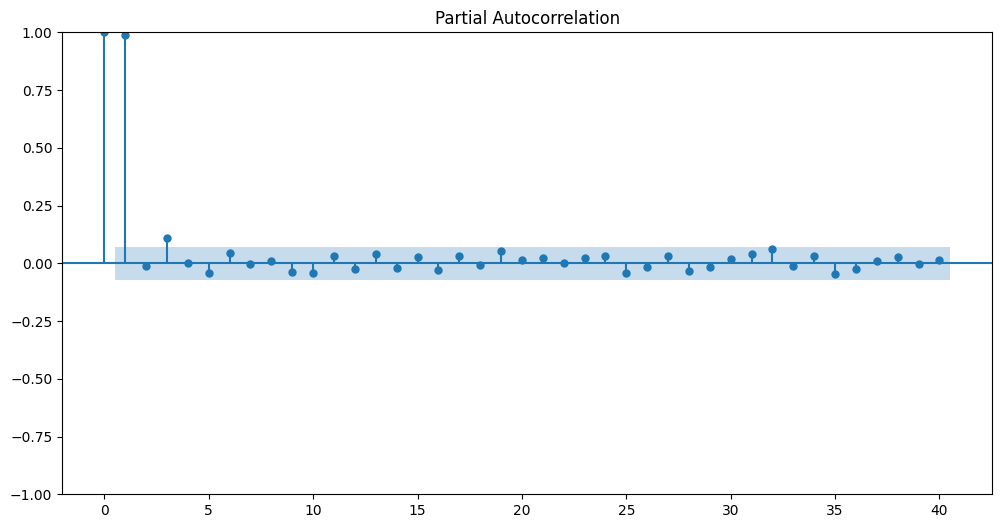

In [7]:
# ACF 그래프
plt.figure(figsize=(12, 6))
plot_acf(df['Adj Close'], lags=40, ax=plt.gca())
plt.title('Autocorrelation')
plt.show()

# PACF 그래프
plt.figure(figsize=(12, 6))
plot_pacf(df['Adj Close'], lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation')
plt.show()

2.6 결과를 해석하세요.

- ACF 그래프는 1부터 시작하여 점차 작아지는 모습을 보여준다. 다만, 값이 음수를 벗어나지는 않는다.
- PACF 그래프는 첫번째 값 이후부터는 값들이 파란 상자 안에 들어가게 되면서 그래프가 끊긴다.

2.7 마지막으로 계절성이 있는지 여부를 확인하겠습니다. statsmodels의 seasonal_decompose 라이브러리를 import하고 plot을 출력하세요.

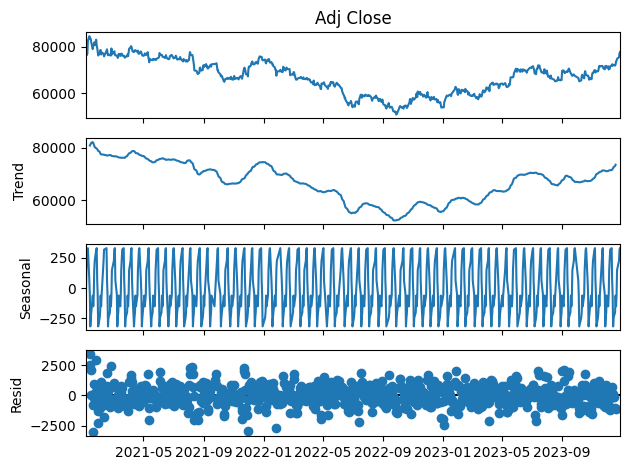

In [8]:
decomposition = seasonal_decompose(df['Adj Close'], model='additive', period=12)   # 월별 데이터에서 연간 계절성 고려
decomposition.plot()
plt.show()

2.8 위 결과를 해석하세요.

- 추세는 2022년 9월까지 꾸준히 하락하다 지속적으로 상승 중이다.
- 거의 월 단위로 계절성이 존재한다.

2.9 위에서 진행한 검정 과정 및 시각화 결과를 종합해봤을 때 현 데이터는 비정상성임을 알 수 있습니다. 따라서 차분을 통해 이를 해결하도록 하겠습니다. 먼저 차분이 어떤 것인지에 대해 설명하세요.

- 시계열의 수준에서 나타내는 변화를 제거하여 시계열의 평균 변화 정도를 일정하게 함
- 추세나 계절성이 제거되도록 함

2.10 1차 차분을 진행하도록 하겠습니다. diff() 함수를 활용해 1차 차분을 진행한 후 ADF Test를 수행하여 정상성 여부를 확인하세요.

In [12]:
df['Adj Close_diff'] = df['Adj Close'].diff()
df.dropna(inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume,Adj Close_diff
Date,,,,,,,
2021-01-05,81600.0,83900.0,81600.0,83900.0,78063.140625,35335669,837.382812
2021-01-06,83300.0,84500.0,82100.0,82200.0,76481.406250,42089013,-1581.734375
2021-01-07,82800.0,84200.0,82700.0,82900.0,77132.703125,32644642,651.296875
2021-01-08,83300.0,90000.0,83000.0,88800.0,82622.250000,59013307,5489.546875
2021-01-11,90000.0,96800.0,89500.0,91000.0,84669.195312,90306177,2046.945312
...,...,...,...,...,...,...,...
2023-12-21,74600.0,75000.0,74300.0,75000.0,73978.890625,13478766,197.273438
2023-12-22,75800.0,76300.0,75400.0,75900.0,74866.632812,14515608,887.742188
2023-12-26,76100.0,76700.0,75700.0,76600.0,75557.109375,13164909,690.476562


In [13]:
d_result = adfuller(df['Adj Close_diff'])

print(f'ADF statistics (Differenced) : {d_result[0]}')
print(f'p-value (Differenced) : {d_result[1]}')

ADF statistics (Differenced) : -21.028619325114526
p-value (Differenced) : 0.0


2.11 추가로 위에서 그려보았던 plot들을 다시 그려보면서 비교를 통해 정상성 여부를 확인해보도록 하겠습니다. ACF PACF plot, 계절성 분해 plot을 그려보세요.

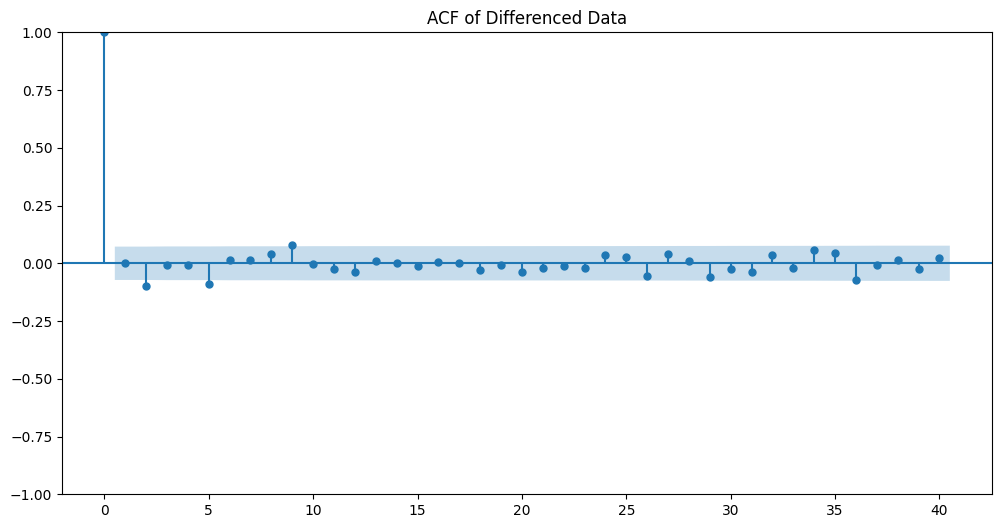

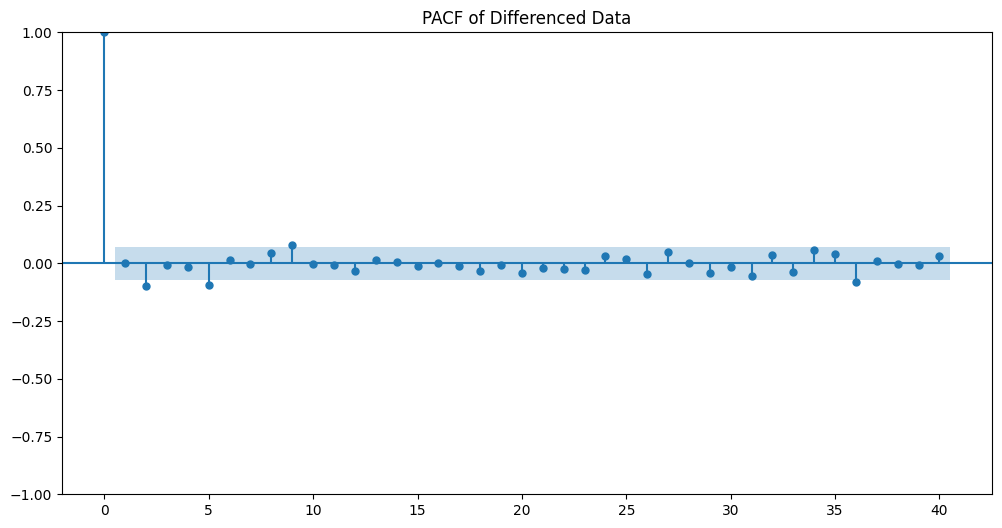

In [14]:
# ACF 그래프
plt.figure(figsize=(12, 6))
plot_acf(df['Adj Close_diff'], lags=40, ax=plt.gca())
plt.title('ACF of Differenced Data')
plt.show()

# PACF 그래프
plt.figure(figsize=(12, 6))
plot_pacf(df['Adj Close_diff'], lags=40, ax=plt.gca())
plt.title('PACF of Differenced Data')
plt.show()

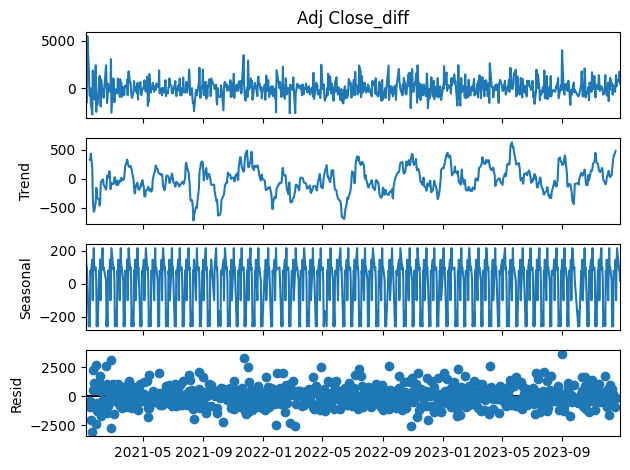

In [15]:
decomposition = seasonal_decompose(df['Adj Close_diff'], model='additive', period=12)   # 월별 데이터에서 연간 계절성 고려
decomposition.plot()
plt.show()

### 3. 예측

3.1 데이터의 정상성을 확인했으니 본격적으로 예측 및 분석을 진행해보도록 하겠습니다.

아래 코드는 예시이므로 예시에서 사용된 모델이 아닌 다른 모델(ex. ARIMAX, ARCH/GARCH, LSTM, Transformer, DLinear etc.)를 사용하고 애플이 아닌 다른 주식을 사용해 예측 및 분석을 진행해주세요(**위에서 진행한 과정 역시 모두 예시이므로 새로운 주식에 대한 전처리 및 정상성 검정을 새로 진행해야 함**).

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
data['Adj Close_diff']

In [ ]:
model = ARIMA(data['Adj Close_diff'], order=(3, 0, 0))  #위에서 차분을 미리 했으므로 차분 값은 0으로 설정
model_fit = model.fit()


model_fit.summary()

C:\Users\bumbk\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\bumbk\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\bumbk\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Adj Close_diff   No. Observations:                 1258
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -2858.574
Date:                Tue, 27 Aug 2024   AIC                           5727.148
Time:                        23:58:51   BIC                           5752.834
Sample:                             0   HQIC                          5736.801
                               - 1258                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1227      0.062      1.969      0.049       0.001       0.245
ar.L1         -0.0434      0.022     -1.986      0.047      -0.086      -0.001
ar.L2         -0.0264      0.023     -1.162      0.245      -0.071       0.018
ar.L3         -0.0158      0.024     -0.658      0.511      -0.063       0.031
sigma2         5.5310      0.149     37.232      0.000       5.240       5.822
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               349.98
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.12   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\bumbk\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


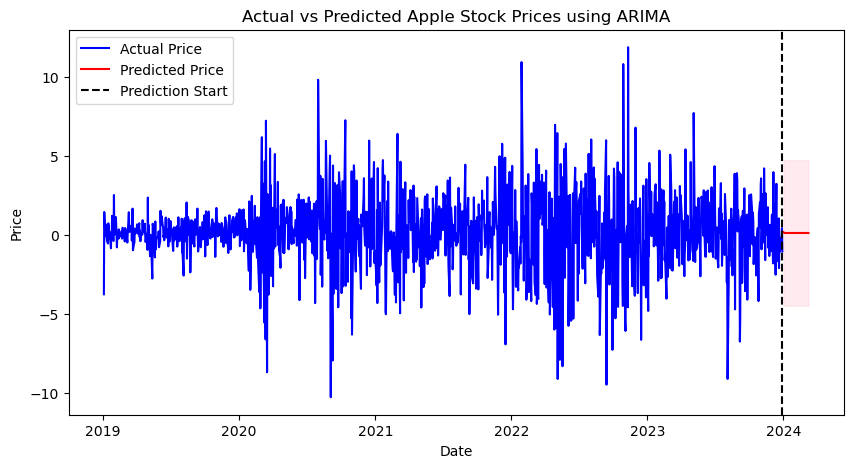

In [ ]:
#예측 수행(50일, 200일해도 달라지지 않았음 ㅠ)
forecast_result = model_fit.get_forecast(steps=50)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

#예측 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(df.index, data['Adj Close_diff'], label='Actual Price', color='blue')
plt.plot(pd.date_range(start=data.index[-1], periods=51, freq='B')[1:], forecast, label='Predicted Price', color='red')
plt.fill_between(pd.date_range(start=data.index[-1], periods=51, freq='B')[1:], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.axvline(x=data.index[-1], color='black', linestyle='--', label='Prediction Start')
plt.title('Actual vs Predicted Apple Stock Prices using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
#실제 데이터 가져오기
actual_data_last_50 = yf.download(ticker, start='2024-01-01', end='2024-03-01')
actual_last_50 = actual_data_last_50[['Close']]


[*********************100%%**********************]  1 of 1 completed


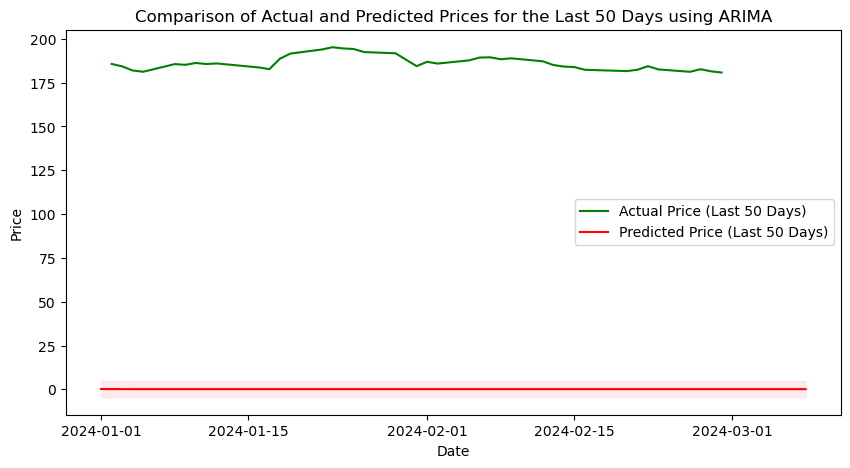

In [ ]:
#실제 데이터와 비교 시각화
plt.figure(figsize=(10, 5))
plt.plot(actual_last_50.index, actual_last_50['Close'], label='Actual Price (Last 50 Days)', color='green')
plt.plot(pd.date_range(start=data.index[-1], periods=51, freq='B')[1:], forecast, label='Predicted Price (Last 50 Days)', color='red')
plt.fill_between(pd.date_range(start=df.index[-1], periods=51, freq='B')[1:], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Comparison of Actual and Predicted Prices for the Last 50 Days using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

ARIMA에서는 성능이 왠지는 모르겠으나 잘 안 나와서 이정도만 하고 넘어가겠습니다. 밑에서 진행할 Prophet 모형의 경우 예측이 제대로 진행되어 추세를 예측하고자 단기적 예측이라 할 수 있는 50일이 아닌 향후 200일을 예측하였습니다.

### Prophet

Prophet 모델이란?
https://wikidocs.net/233162

In [ ]:
from prophet import Prophet

In [ ]:
###Prophet의 경우 ARIMA와 검정 및 전처리 과정이 약간 달라 새로 진행하였으며 보다 정확한 추세 예측을 위해 200일까지 예측하였습니다.###


ticker = 'AAPL'
data = yf.download(ticker, start='2019-01-01', end='2024-01-01')

df = data.reset_index()[['Date', 'Close']]
df.columns = ['ds', 'y']  #Prophet에서는 날짜 컬럼을 'ds', 값 컬럼을 'y'로 설정해야 함

[*********************100%%**********************]  1 of 1 completed


In [ ]:
#모델 설정(파라미터는 따로 설정하지 않고 진행했으나 보다 정확한 예측을 위해 수정하는 것도 좋음)
model = Prophet()
model.fit(df)

00:06:19 - cmdstanpy - INFO - Chain [1] start processing
00:06:19 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
#200일간의 예측 진행
future = model.make_future_dataframe(periods=200)
forecast = model.predict(future)

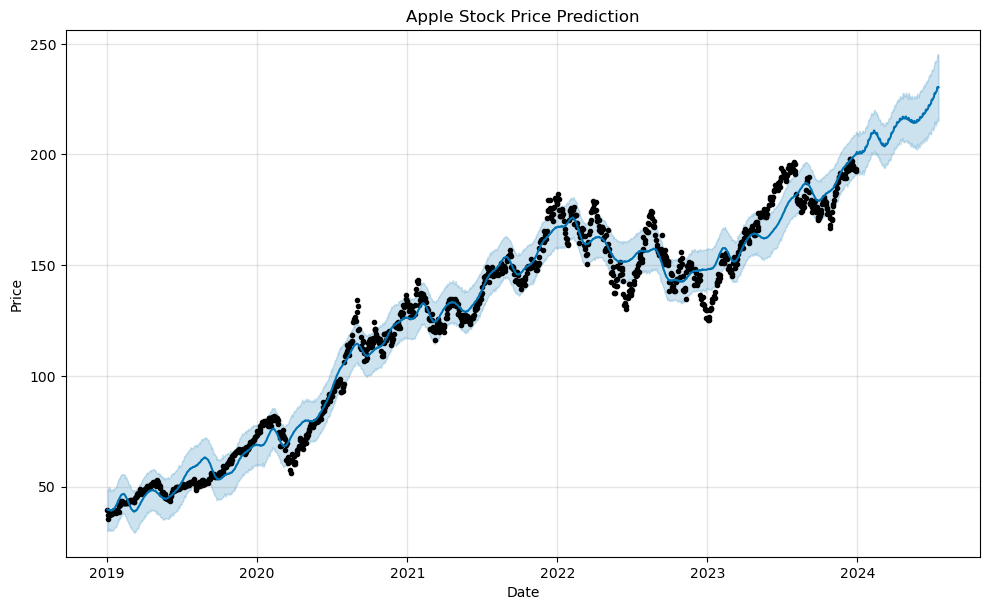

In [ ]:
# 예측 결과 시각화
fig1 = model.plot(forecast)
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

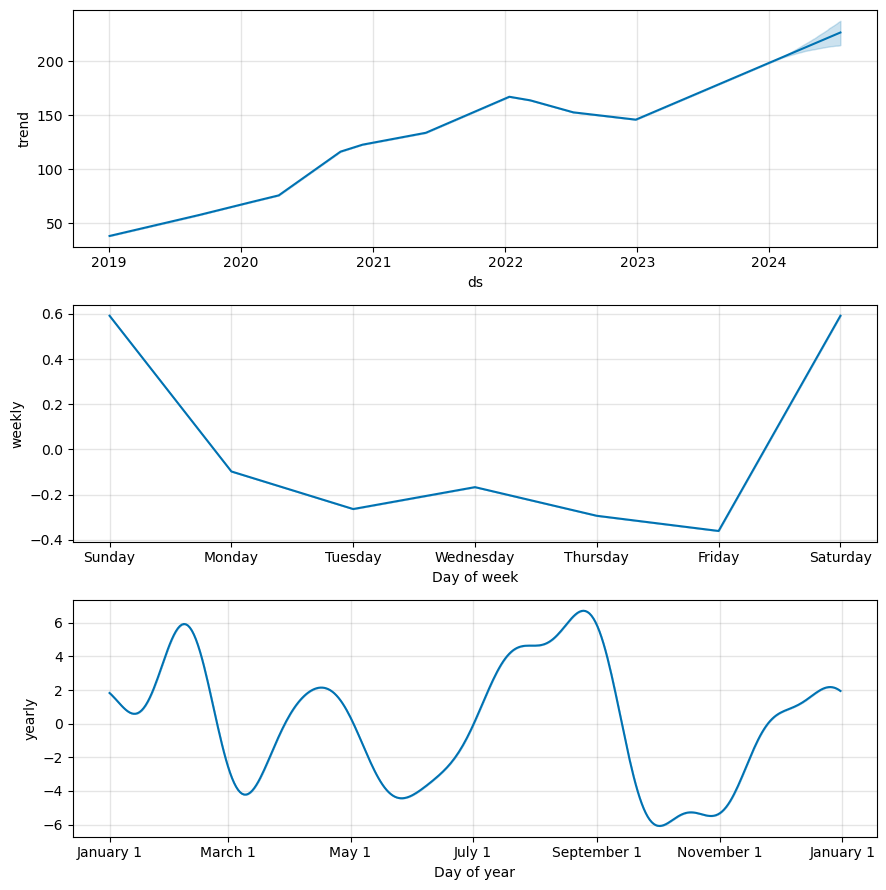

In [ ]:
#트렌드 및 주기성 시각화
fig2 = model.plot_components(forecast)
plt.show()

In [ ]:
#마지막 200일의 실제 주가 데이터 가져오기
actual_data_last_50 = yf.download(ticker, start='2024-01-01', end='2024-08-01')
actual_last_50 = actual_data_last_50.reset_index()[['Date', 'Close']]
actual_last_50.columns = ['ds', 'y']

[*********************100%%**********************]  1 of 1 completed


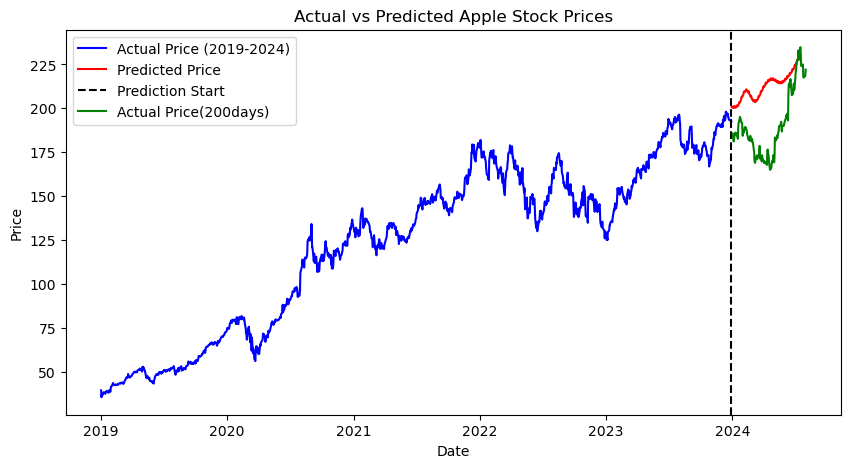

In [ ]:
#실제 값과 비교 시각화
plt.figure(figsize=(10, 5))
plt.plot(df['ds'], df['y'], label='Actual Price (2019-2024)', color='blue')

plt.plot(forecast['ds'][len(df):], forecast['yhat'][len(df):], label='Predicted Price', color='red') ##전체 예측값 중 200일 이후 것만 사용
plt.axvline(x=df['ds'].iloc[-1], color='black', linestyle='--', label='Prediction Start')
plt.plot(actual_last_50['ds'], actual_last_50['y'], label='Actual Price(200days)', color='green')
plt.title('Actual vs Predicted Apple Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


예시에서는 전통적 시계열 모형인 ARIMA 보다 최신 기법인 Prophet이 보다 좋은 성능을 보였습니다.

사실 ARIMA로도 좋은 예측을 진행할 수는 있으나 조금 간단하게 진행하였으며(죄송합니다..시간관계상 ㅠ) SARIMA, ARIMAX와 같이 발전된 모형을 사용하는 것도 방법입니다.

예시보다 좋은 예측을 진행하여 주시길 바라며 단순히 시각화하는 것을 넘어서 ***RMSE***나 ***MAE***와 같은 성능지표를 활용해 정량적 평가를 진행해주시면 좋을 것 같습니다.

### SARIMA(계절성 ARIMA) 모델 사용
 - import SARIMAX 모델

In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np

In [17]:
pre = df['Adj Close_diff']
pre

,Adj Close_diff
Date,
2021-01-05,837.382812
2021-01-06,-1581.734375
2021-01-07,651.296875
2021-01-08,5489.546875
2021-01-11,2046.945312
...,...
2023-12-21,197.273438
2023-12-22,887.742188
2023-12-26,690.476562


In [18]:
train_data = pre[:-50]
test_data = pre[-50:]

SARIMA 모델의 경우 기존 ARIMA 모델에서 seasonal_order이라는 계절성에 대한 파라미터 지정을 포함한다.

In [68]:
# SARIMA 모델 학습
# (p, d, q) - AR , (P, D, Q, s) - Seasonal
model = SARIMAX(train_data, order=(5, 0, 5), seasonal_order=(5, 0, 5, 12))
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [69]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     Adj Close_diff   No. Observations:                  686
Model:             SARIMAX(5, 0, 5)x(5, 0, 5, 12)   Log Likelihood               -5640.046
Date:                            Mon, 07 Oct 2024   AIC                          11322.091
Time:                                    15:03:41   BIC                          11417.240
Sample:                                         0   HQIC                         11358.906
                                            - 686                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8006      0.118      6.766      0.000       0.569       1.033
ar.L2          0.0583      0.041      1.436      0.151      -0.021       0.138
ar.L3         -0.1232      0.039     -3.154      0.002      -0.200      -0.047
ar.L4         -0.8568      0.038    -22.410      0.000      -0.932      -0.782
ar.L5          0.7473      0.118      6.326      0.000       0.516       0.979
ma.L1         -0.7853      0.105     -7.479      0.000      -0.991      -0.579
ma.L2         -0.1450      0.029     -4.984      0.000      -0.202      -0.088
ma.L3          0.1408      0.028      4.985      0.000       0.085       0.196
ma.L4          0.8949      0.027     33.110      0.000       0.842       0.948
ma.L5         -0.8375      0.102     -8.209      0.000      -1.037      -0.638
ar.S.L12      -0.4965      0.122     -4.067      0.000      -0.736      -0.257
ar.S.L24       0.2810      0.129      2.171      0.030       0.027       0.535
ar.S.L36      -0.3652      0.107     -3.427      0.001      -0.574      -0.156
ar.S.L48       0.5980      0.115      5.218      0.000       0.373       0.823
ar.S.L60       0.8536      0.129      6.602      0.000       0.600       1.107
ma.S.L12       0.4798      0.141      3.402      0.001       0.203       0.756
ma.S.L24      -0.2297      0.184     -1.249      0.212      -0.590       0.131
ma.S.L36       0.3478      0.178      1.953      0.051      -0.001       0.697
ma.S.L48      -0.6208      0.156     -3.985      0.000      -0.926      -0.315
ma.S.L60      -0.7786      0.181     -4.299      0.000      -1.134      -0.424
sigma2       7.69e+05   6.39e+04     12.029      0.000    6.44e+05    8.94e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):               192.75
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             0.56
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.17e+14. Standard errors may be unstable.
"""

In [70]:
# 향후 50일 예측
forecast = model_fit.get_forecast(steps=50)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


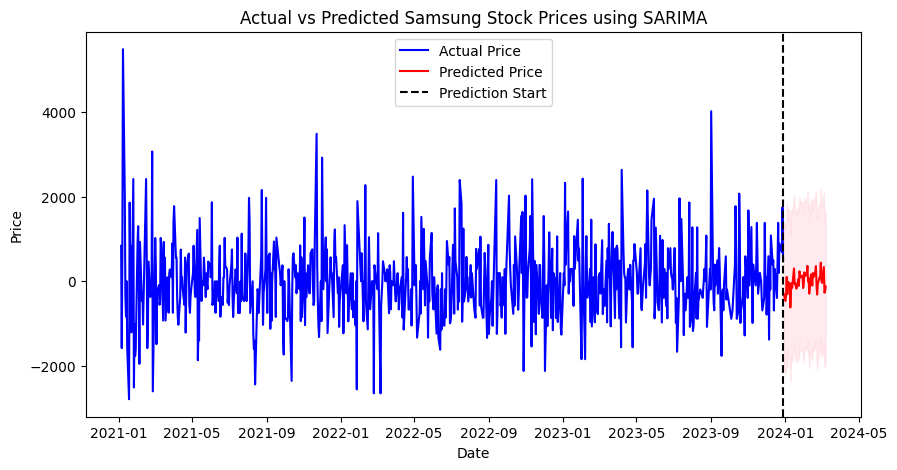

In [71]:
# 예측 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Adj Close_diff'], label='Actual Price', color='blue')
plt.plot(pd.date_range(start=df.index[-1], periods=51, freq='B')[1:], forecast_mean, label='Predicted Price', color='red')
plt.fill_between(pd.date_range(start=df.index[-1], periods=51, freq='B')[1:], forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.axvline(x=df.index[-1], color='black', linestyle='--', label='Prediction Start')
plt.title('Actual vs Predicted Samsung Stock Prices using SARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

2024년 1월 1일 부터 50일간의 수정종가 예측

In [72]:
# RMSE 계산
rmse = np.sqrt(mean_squared_error(test_data, forecast_mean[:len(test_data)]))
print(f'RMSE: {rmse}')

# MAE 계산
mae = mean_absolute_error(test_data, forecast_mean[:len(test_data)])
print(f'MAE: {mae}')

RMSE: 754.1699524458735
MAE: 583.7305515981678


In [73]:
# 2024년 이후 약 50일 이후의 실제 삼성전자 주식 데이터
start = "2024-01-01"
end = "2024-03-31"
df2 = yf.download(ticker, start, end)
df2 = df2[['Close']]
df2

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2024-01-02,79600.0
2024-01-03,77000.0
2024-01-04,76600.0
2024-01-05,76600.0
2024-01-08,76500.0
...,...
2024-03-25,78200.0
2024-03-26,79900.0
2024-03-27,79800.0


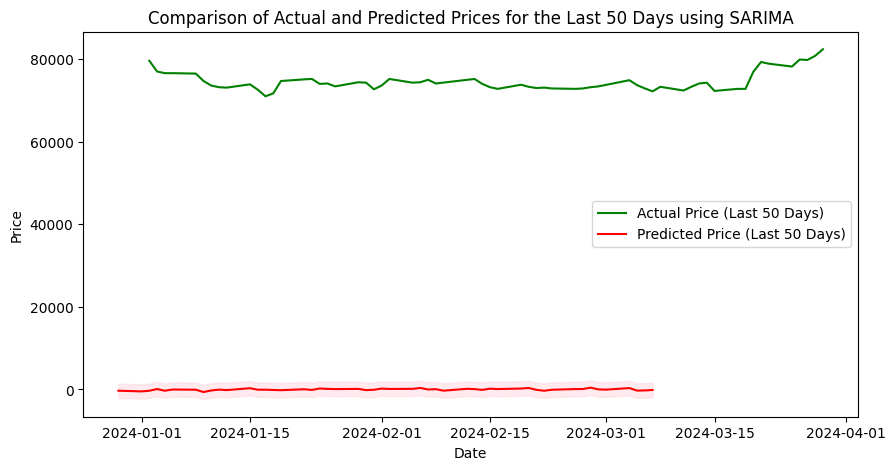

In [75]:
# 실제 주식과 비교
plt.figure(figsize=(10, 5))
plt.plot(df2.index, df2['Close'], label='Actual Price (Last 50 Days)', color='green')
plt.plot(pd.date_range(start=df.index[-1], periods=51, freq='B')[1:], forecast_mean, label='Predicted Price (Last 50 Days)', color='red')
plt.fill_between(pd.date_range(start=df.index[-1], periods=51, freq='B')[1:], forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Comparison of Actual and Predicted Prices for the Last 50 Days using SARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

예측값 자체가 거의 0 근처만을 오가서 효과적인 예측 결과가 나오지 않음.(파라미터 값을 높이면 조금씩 유의미한 변화는 생기나, 그래도 결국 0근처임)